## Class 4-2: Feature selection

In [1]:
import pandas as pd
from sklearn import tree
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline


In this class we're going to learn more about setting up problems for machine learning. The actual `fit()` call is the easy part; most of the work of applying learning machine learning is usually setting up the data.

Our first task today will be trying to figure out when a plane is likely to be late. We'll be using
 a data set of arrivals at JFK in 2015
 
Then we'll build a classifer very similar to one that was used at the New York Times to categorize occupation descriptions in campaign finance data.

## 1. Guessing late flights

In [2]:
# load flight data
fl = pd.read_csv('ontime_reports_may_2015_ny.csv')
fl.shape

(45648, 21)

In [3]:
# take a look
fl.head()

,YEAR,MONTH,DAY_OF_MONTH,CARRIER,FL_NUM,ORIGIN,DEST,DEP_DELAY,ARR_DELAY,CANCELLED,...,DIVERTED,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 20
0,2015,5,1,AA,44,LAS,JFK,-6.0,-17.0,0.0,...,0.0,294.0,273.0,2248.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,5,2,AA,44,LAS,JFK,-8.0,-14.0,0.0,...,0.0,299.0,280.0,2248.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,5,3,AA,44,LAS,JFK,0.0,-11.0,0.0,...,0.0,294.0,274.0,2248.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,5,4,AA,44,LAS,JFK,-11.0,4.0,0.0,...,0.0,320.0,275.0,2248.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,5,5,AA,44,LAS,JFK,-4.0,-18.0,0.0,...,0.0,291.0,270.0,2248.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# what are the columns?
fl.columns

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'CARRIER', 'FL_NUM', 'ORIGIN', 'DEST',
       'DEP_DELAY', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 20'],
      dtype='object')

In [5]:
# distribution of each column
fl.describe()

,YEAR,MONTH,DAY_OF_MONTH,FL_NUM,DEP_DELAY,ARR_DELAY,CANCELLED,DIVERTED,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 20
count,45648.0,45648.0,45648.000000,45648.000000,44920.000000,44703.000000,45648.000000,45648.000000,44703.000000,44703.000000,45648.000000,7854.000000,7854.000000,7854.000000,7854.000000,7854.000000,0.0
mean,2015.0,5.0,15.945759,1696.717885,10.901158,2.456099,0.016912,0.003790,167.442856,139.886853,1019.913819,18.123631,3.029157,25.238350,0.061879,26.114464,NaN
std,0.0,0.0,8.893316,1422.585661,43.352321,46.814900,0.128943,0.061446,88.119647,85.685890,710.691183,51.011949,20.737081,48.335216,1.564925,50.348603,NaN
min,2015.0,5.0,1.000000,1.000000,-28.000000,-69.000000,0.000000,0.000000,43.000000,25.000000,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,2015.0,5.0,8.000000,507.000000,-5.000000,-19.000000,0.000000,0.000000,104.000000,77.000000,502.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,2015.0,5.0,16.000000,1289.000000,-2.000000,-9.000000,0.000000,0.000000,149.000000,122.000000,828.000000,0.000000,0.000000,6.000000,0.000000,0.000000,NaN
75%,2015.0,5.0,24.000000,2404.000000,6.000000,5.000000,0.000000,0.000000,199.000000,168.000000,1183.000000,17.000000,0.000000,28.000000,0.000000,31.000000,NaN
max,2015.0,5.0,31.000000,6520.000000,1324.000000,1318.000000,1.000000,1.000000,702.000000,648.000000,4983.000000,1318.000000,732.000000,676.000000,85.000000,846.000000,NaN


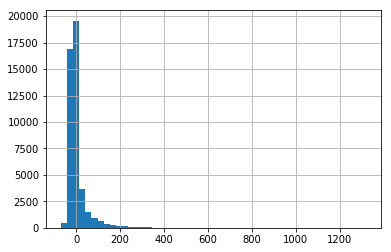

In [6]:
# Let's look at the column we'll try to predict
fl.ARR_DELAY.hist(bins=50)

So what makes planes delayed? How would we guess, given all other information, whether the plane will be on time? We can look at various factors to try to find out, including which airline was flying and where they were going.

In [7]:
(fl.groupby('CARRIER').median()).sort_values('ARR_DELAY')['ARR_DELAY']

CARRIER
B6   -12.0
AA   -10.0
DL   -10.0
MQ    -8.0
UA    -8.0
WN    -8.0
EV    -7.0
OO    -6.0
US    -6.0
F9    -4.5
VX    -4.0
NK    -2.0
HA     1.0
Name: ARR_DELAY, dtype: float64

In [8]:
(fl.groupby('ORIGIN').median()).sort_values('ARR_DELAY')['ARR_DELAY']

ORIGIN
STT   -19.5
EWR   -18.0
SRQ   -18.0
SJU   -18.0
IAD   -17.0
BTV   -17.0
SAN   -16.5
PWM   -16.5
PSE   -16.0
MSY   -15.0
BQN   -15.0
MKE   -14.0
SAT   -13.5
SLC   -13.0
BGR   -13.0
LAX   -13.0
PDX   -13.0
SYR   -13.0
DEN   -13.0
LGB   -12.0
SEA   -12.0
FLL   -12.0
JAX   -12.0
ISP   -12.0
ALB   -12.0
OMA   -12.0
BUF   -12.0
JFK   -12.0
HPN   -11.0
CHS   -11.0
       ... 
CMH    -7.0
ATL    -7.0
MCI    -7.0
BOS    -7.0
PHX    -6.5
GRR    -6.5
RIC    -6.5
STL    -6.0
RNO    -6.0
ELM    -6.0
MDW    -6.0
RDU    -6.0
MIA    -6.0
CAE    -4.5
DTW    -4.0
IAH    -4.0
DFW    -4.0
GSO    -4.0
ORF    -3.0
SDF    -3.0
HOU    -2.0
BNA    -2.0
BWI    -2.0
CLT    -2.0
DAY    -1.5
MYR    -1.5
PIT     1.0
CHO     3.5
HNL     4.0
DAL     8.0
Name: ARR_DELAY, Length: 92, dtype: float64

The first surprise is that, overall, it seems most flights arrive early!

But there does seem to be information here -- some airports tend to be delayed a lot more than others. Of course, many other variables will be predictive. 

Of course, we should expect that the departure delay correlates strongly with the arrival delay.

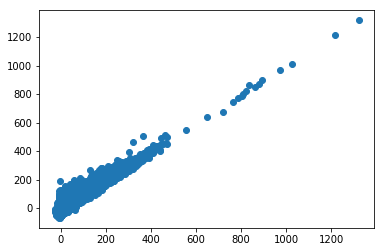

In [9]:
plt.scatter(fl.DEP_DELAY, fl.ARR_DELAY)

### Encoding the columns

We want to use a decision tree to predict whether the plane will be delayed. Before we can do that, we're going to frame the problem a little more specifically.

- We want to predict: will the plane have an ARR_DELAY greater than 0, a binary variable?
- From data: Everything we would know before the plane takes off. So, not the other DELAY variables, CANCELLED and DIVERTED, or ACTUAL_ELAPSED_TIME.

The first problem is that we have a bunch of categorical varaibles that need to be turned into numerical variables. This means the first step is some data cleaning.

Meanwhile the output we want to predict, `ARR_DELAY`, is numerical not categorical. To use a classifier, we have to guess... classes. So to start with, let's divide the flights into delayed and not delayed.

In [10]:
# Predict only whether the arrival was >0 minutes late
fl_output = fl['ARR_DELAY'].apply(lambda x: 1 if x>0 else 0 )
fl_output.head()

0    0
1    0
2    0
3    1
4    0
Name: ARR_DELAY, dtype: int64

In [11]:
# Keep only variables we know before the flight leaves. We'll start with the variables that are already numeric
fl_input = fl[['YEAR', 'MONTH', 'DAY_OF_MONTH', 'AIR_TIME', 'DISTANCE']]

In [12]:
# But what about the 'CARRIER', 'ORIGIN', and 'DEST' columns? They're not numeric, or even ordered 
fl['ORIGIN'].value_counts().head()

LGA    9428
JFK    8880
ORD    1837
BUF    1675
ATL    1603
Name: ORIGIN, dtype: int64

In [13]:
# To turn categorical variables into numeric variables, we create one binary "dummy" variable for each category
# To demonstrate how this works:
df = pd.DataFrame({'mycat':['b','b','a','c','a','b']})
df

,mycat
0,b
1,b
2,a
3,c
4,a
5,b


In [14]:
pd.get_dummies(df['mycat'],prefix='category')

,category_a,category_b,category_c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


In [15]:
# Now we have to create a series of dummy variables, 
# one dummy variable column for each value of each of the origina categorical columns
def add_dummy_vars_for_col(df, colname):
    dummy_vars = pd.get_dummies(fl[colname], prefix=colname)
    return pd.concat([df, dummy_vars], axis=1)

fl_input = add_dummy_vars_for_col(fl_input, 'CARRIER')
fl_input = add_dummy_vars_for_col(fl_input, 'ORIGIN')
fl_input = add_dummy_vars_for_col(fl_input, 'DEST')

# Flight number is a number... but it's really categorical.
# Flight 45 is not more closely related to flight 60 than flight 200.
fl_input = add_dummy_vars_for_col(fl_input, 'FL_NUM')

fl_input.head()


,YEAR,MONTH,DAY_OF_MONTH,AIR_TIME,DISTANCE,CARRIER_AA,CARRIER_B6,CARRIER_DL,CARRIER_EV,CARRIER_F9,...,FL_NUM_6074,FL_NUM_6082,FL_NUM_6119,FL_NUM_6132,FL_NUM_6153,FL_NUM_6229,FL_NUM_6257,FL_NUM_6275,FL_NUM_6482,FL_NUM_6520
0,2015,5,1,273.0,2248.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2015,5,2,280.0,2248.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,5,3,274.0,2248.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2015,5,4,275.0,2248.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2015,5,5,270.0,2248.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
fl_input.shape

(45648, 2120)

### Fitting and testing the tree

In [17]:
# Put the features and the target column back together so we can split them together into training and test sets
feature_cols = list(fl_input.columns)
target_col = ['ARR_DELAY']
features_and_target = pd.concat([fl_input,fl_output],axis=1)



In [18]:
# Finally, need to lose any row that have nulls. Let's keep track of how many
features_and_target.shape

(45648, 2121)

In [19]:
features_and_target = features_and_target.dropna(how='any')

In [20]:
features_and_target.shape

(44703, 2121)

In [21]:
train, test = train_test_split(features_and_target, test_size=0.2)

In [22]:
# Fit a decision tree to the test data
x_train = train[feature_cols].values
y_train = train[target_col].values

dt = tree.DecisionTreeClassifier()
dt.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
# Let's see how well it did on the training
y_train_pred = dt.predict(x_train)
metrics.accuracy_score(y_train_pred, y_train)

1.0

In [24]:
# Ok, but seriously, on data it's never seen before?
x_test = test[feature_cols].values
y_test = test[target_col].values
y_test_pred = dt.predict(x_test)
metrics.accuracy_score(y_test_pred, y_test)

0.69377027178167994

In [25]:
metrics.confusion_matrix(y_test_pred, y_test)

array([[5042, 1557],
       [1181, 1161]])

There's a better way of testing the accuracy of a classifier: more reliable and fewer lines of code. The idea is to break the original data into K pieces. Then we build K different classifiers, each of which uses one of the K pieces as test data, while the other K-1 pieces become the training data. Then we average the accuracy from each run. 

This is called "cross validation", and there's a function to do it automatically.

In [26]:
from sklearn.model_selection import cross_val_score


In [27]:
my_classifier = tree.DecisionTreeClassifier()
scores = cross_val_score(my_classifier, 
                         features_and_target[feature_cols].values, 
                         features_and_target[target_col].values,
                         cv=5)
scores


array([ 0.69567163,  0.68963203,  0.46281177,  0.54239374,  0.57237136])

In [28]:
scores.mean()

0.59257610480037293

## 2. Classifying text

So far, we've classified data points which have binary, numerical, or categorical values. What about classifying text? To do that, first we have to turn the text into vectors. Yup, it's document vector time once more!

This code was adapted from a New York Times project to standardize campaign finance data to enable new types of analyses. Specifically, it tries to categorize a free-form occupation/employer string into a discrete job category (for example, the strings "LAWYER" and "ATTORNEY" would both be categorized under "LAW"). 

This classifier uses one-letter category codes (e.g. "L" for "law") which are specifically designed for analyzing campaign finance donations, and are maintained by the Center for Responsive Politics. Full documentation [here](https://www.opensecrets.org/resources/ftm/ch12p1.php).

This section of the notebook was adapted from the [2015 version](https://github.com/datapolitan/lede_algorithms/blob/master/class2_1/EDA_Review.ipynb) of this course by Chase Davis and Richard Dunks, with grateful permission.


In [29]:
import csv, re, string
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [30]:
# Some basic setup for data-cleaning purposes
punctuation = re.compile('[' + re.escape(string.punctuation) + ']' )
valid_occupation_codes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'T', 'X', 'Z']

In [31]:
# Load the training data. The goal is to predict the first letter of the occupation code
df = pd.read_csv('category-training.csv',names=['Title','Employer','Code'])
df.head()

,Title,Employer,Code
0,Owner,First Priority Title Llc,F4300
1,SENIOR PARTNER,ARES MANAGEMENT,Z9500
2,CEO,HB AGENCY,Z9500
3,AKERS & ARMEY INSURANCE,NaN,F3100
4,OWNER,OPTIONCARE,Y4000


In [32]:
# Concatenate the occupation and employer strings together and remove punctuation. 
# Both together will be used in prediction
df['text'] = df['Title'] + ' ' + df['Employer']
df['text'] = df['text'].str.replace(punctuation, ' ')  # replace punctuation with spaces to preserve word boundaries
df.head(10)

,Title,Employer,Code,text
0,Owner,First Priority Title Llc,F4300,Owner First Priority Title Llc
1,SENIOR PARTNER,ARES MANAGEMENT,Z9500,SENIOR PARTNER ARES MANAGEMENT
2,CEO,HB AGENCY,Z9500,CEO HB AGENCY
3,AKERS & ARMEY INSURANCE,NaN,F3100,NaN
4,OWNER,OPTIONCARE,Y4000,OWNER OPTIONCARE
5,VI,NATIONAL COUNCIL OF JEWISH WOMEN,J5100,VI NATIONAL COUNCIL OF JEWISH WOMEN
6,AESTHETIC & RECONSTRUCTIV,NaN,H1000,NaN
7,MINER,MCCOY ELKHORN COAL CORPORATION,E1210,MINER MCCOY ELKHORN COAL CORPORATION
8,VICE PRESIDENT,BAYSTATE HEALTH,H0000,VICE PRESIDENT BAYSTATE HEALTH
9,CHIEF EXEC OFF,LARTA INST/CHIEF EXEC OFF,Y4000,CHIEF EXEC OFF LARTA INST CHIEF EXEC OFF


In [33]:
# Take only the first letter of the occupation code as the prediction target
df['target'] = df['Code'].str[0]

In [34]:
df.head()

,Title,Employer,Code,text,target
0,Owner,First Priority Title Llc,F4300,Owner First Priority Title Llc,F
1,SENIOR PARTNER,ARES MANAGEMENT,Z9500,SENIOR PARTNER ARES MANAGEMENT,Z
2,CEO,HB AGENCY,Z9500,CEO HB AGENCY,Z
3,AKERS & ARMEY INSURANCE,NaN,F3100,NaN,F
4,OWNER,OPTIONCARE,Y4000,OWNER OPTIONCARE,Y


In [35]:
# We still have lots of empty text fields though
df.text.isnull().sum()

24190

In [36]:
df.dropna(how='any', inplace=True)
len(df)

75810

In [37]:
# My notebook keeps crashing, so I'm going to take only 20,000 rows
df = df.sample(20000).reset_index(drop=True)
len(df)

20000

### Document vectors, again
We now have our text and the training labels. From here we need to turn that text into features... remember document vectors? But fun fact: the CountVectorizer (and TfIdfVectorizer) don't actually need a separate tokenizer. It's super simple to do quick and dirty document vectors.

We're also going to use the `min_df=2` option which means: throw out any word that doesn't appear in at least two documents. This will cut down the number of features by a factor of three, and generally speed up this slow notebook.

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

In [55]:
# Make our training data into vectors!
vectorizer = CountVectorizer(stop_words='english', min_df=2)
matrix = vectorizer.fit_transform(df.text)

In [56]:
vectorizer.get_feature_names()[:20]

['10',
 '11',
 '13',
 '1st',
 '2000',
 '2004',
 '2012',
 '20th',
 '21',
 '21st',
 '22',
 '2nd',
 '360',
 '3m',
 '3rd',
 '47',
 '800',
 '95',
 'aaa',
 'aaron']

In [57]:
# Here are the actual document vectors. Because the "documents" are so short, almost every element is zero.
vectors = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
vectors.head()

,10,11,13,1st,2000,2004,2012,20th,21,21st,...,zachry,zack,zc,zetlin,ziegler,zimmerman,zook,zuckerman,zurich,zwirn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Using a decision tree for text classification
This goes pretty much as we've done it before. Really most of the work is data wrangling.

In [58]:
# Glue the occupation codes back together with the document vectors, into one dataframe
features_and_target = pd.concat([df.target, vectors],axis=1)
features_and_target.head()

,target,10,11,13,1st,2000,2004,2012,20th,21,...,zachry,zack,zc,zetlin,ziegler,zimmerman,zook,zuckerman,zurich,zwirn
0,X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Y,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Y,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,X,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# Split off some test data
train, test = train_test_split(features_and_target, test_size=0.2)

In [60]:
# Build a decision tree on the training data
# Normally we would use 
#  train.drop('target', axis=1).values
#  train[['target']].values 
# But 'target' is also a feature name, because it appears in the bill titles! So we just use direct numeric indexing 
x_train = train.iloc[:,1:].values
y_train = train.iloc[:,0].values

dt = tree.DecisionTreeClassifier()
dt.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [61]:
# We're only going to test how well it did out-of-sample, because the in-sample result will always be nearly perfect
x_test = test.iloc[:,1:].values
y_test = test.iloc[:,0].values
y_test_pred = dt.predict(x_test)
metrics.accuracy_score(y_test_pred, y_test)

0.45650000000000002

This is really not very good accuracy, less than 50%. To see if we can do better, first let's look at the confusion matrix to see where it got confused.

In [62]:
metrics.confusion_matrix(y_test_pred, y_test)

array([[ 26,   0,   1,   0,   0,   4,   5,   0,   4,   1,   0,   2,   0,
          0,  10,   0],
       [  1,  77,   4,   0,   5,   6,   4,   0,   5,   0,   1,   0,   1,
          3,  28,   4],
       [  1,   6,  50,   4,   2,  11,   9,   6,   8,   2,   0,   2,   3,
          4,  27,   6],
       [  0,   3,   2,   0,   0,   1,   2,   0,   1,   0,   0,   0,   1,
          0,   4,   0],
       [  2,   0,   1,   0,  43,   2,   2,   0,   3,   1,   0,   0,   3,
          0,  13,   2],
       [  2,  10,   5,   0,   6, 289,  17,  17,  35,  11,   1,   4,   7,
          5, 113,  10],
       [  6,   1,   5,   2,   2,  10,  71,   6,  16,   6,   0,   6,   4,
          3,  67,   4],
       [  2,   4,   2,   0,   1,   5,   7, 225,  25,   3,   1,   0,   4,
          4,  58,  17],
       [  3,   2,  11,   0,   1,  26,   6,  15,  19,  10,   1,   3,   3,
          3,  53,   6],
       [  0,   3,   6,   1,   4,   7,   5,   1,  22, 149,   0,   1,   0,
          2,  76,  10],
       [  1,   0,   0,   0,   

Not very helpful. We need to handle our categorical target variable better.

### Printing out nice category names

We are going to build a new classifier, using Pandas categorical types for the target column. This will let us print out a more sensible confusion matrix.


In [47]:
# Convert to categorical type
df['target'] = df['target'].astype('category')

In [48]:
# If we print it out, it looks like nothing has changed... except the type is now "category"
df.target.head()


0    X
1    Y
2    B
3    Y
4    X
Name: target, dtype: category
Categories (16, object): [A, B, C, D, ..., T, X, Y, Z]

In [49]:
# Pandas has invented numbers for each of our letter codes
df.target.cat.categories

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'T', 'X',
       'Y', 'Z'],
      dtype='object')

In [50]:
# And these numbers are what is actually stored in the column now
df.target.head().cat.codes

0    13
1    14
2     1
3    14
4    13
dtype: int8

In [51]:
# Repeat all of our model building with the training labels in this new type of column
features_and_target = pd.concat([df.target, vectors],axis=1)
train, test = train_test_split(features_and_target, test_size=0.2)

In [52]:
x_train = train.iloc[:,1:].values
y_train = train.iloc[:,0].values

dt = tree.DecisionTreeClassifier()
dt.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [53]:
x_test = test.iloc[:,1:].values
y_test = test.iloc[:,0].values
y_test_pred = dt.predict(x_test)
metrics.accuracy_score(y_test_pred, y_test)

0.43149999999999999

In [54]:
# Now that we have the category names, we can make a much prettier confusion matrix
truecats = "True " + df.target.cat.categories
predcats = "Guessed " + df.target.cat.categories
pd.DataFrame(metrics.confusion_matrix(y_test_pred, y_test, labels=df.target.cat.categories), columns=predcats, index=truecats)

,Guessed A,Guessed B,Guessed C,Guessed D,Guessed E,Guessed F,Guessed G,Guessed H,Guessed J,Guessed K,Guessed L,Guessed M,Guessed T,Guessed X,Guessed Y,Guessed Z
True A,25,0,0,0,0,3,8,1,2,1,0,1,1,0,7,0
True B,0,65,1,1,3,5,2,2,4,1,0,2,0,2,25,1
True C,3,7,64,2,4,14,16,4,14,2,0,4,3,1,108,12
True D,0,0,2,2,1,0,0,0,0,0,0,0,0,0,0,0
True E,2,0,1,0,28,3,1,2,1,0,0,1,0,0,12,0
True F,4,8,8,3,9,319,12,16,30,5,1,9,4,9,144,20
True G,3,12,13,1,4,13,75,12,14,11,0,4,6,2,87,9
True H,3,4,9,0,4,6,5,268,21,3,1,2,4,8,106,16
True J,11,6,12,1,5,11,32,26,42,12,3,1,8,23,119,14
True K,0,0,3,2,2,9,3,0,8,130,0,1,0,7,43,6
